In [1]:
# Importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
import pickle
plt.rcParams['figure.figsize'] = 15, 10


resize_depth = 128

# Initializing the transform for the dataset
transform = torchvision.transforms.Compose([
	torchvision.transforms.ToTensor(),
	torchvision.transforms.Normalize((0.5), (0.5))
])


with open(f"../../data/scratch/img_pairs_{resize_depth}.pkl", "rb") as f:
	train_dataset = pickle.load(f)

transformed_train_dataset = [(transform(image), transform(label)) for image, label in train_dataset]

n = len(transformed_train_dataset)
train_data = transformed_train_dataset[:int(n*0.9)]
val_data = transformed_train_dataset[int(n*0.9):]





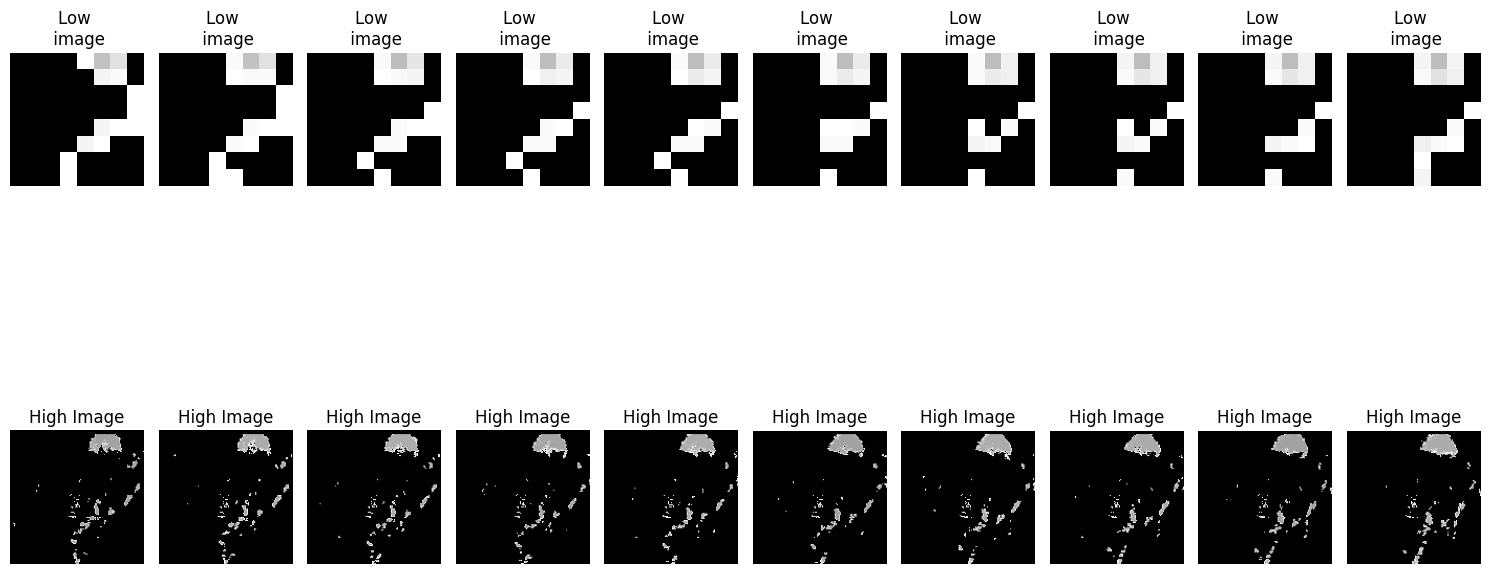

In [2]:
# load pickle file from ../data/scratch/img_pairs.pkl




counter = 1


iplus = 200

for idx in range(10):
	idx = idx + iplus
	val = transformed_train_dataset[idx][0]
	plt.subplot(2, 10, counter)
	plt.title("Low \n image")
	plt.imshow(val.reshape(8, 8), cmap='gray')
	plt.axis('off')

	# Incrementing subplot counter
	counter += 1

for idx in range(10):
    idx = idx + iplus
    val = transformed_train_dataset[idx][1]
    plt.subplot(2, 10, counter)
    plt.imshow(val.reshape(resize_depth, resize_depth), cmap='gray')
    plt.title("High Image")
    plt.axis('off')

	# Incrementing subplot counter
    counter += 1

plt.tight_layout()
plt.show()


In [3]:
# Creating a DeepAutoencoder class
class DeepAutoencoder(torch.nn.Module):
	def __init__(self):
		super().__init__()
		self.decoder = self.generate_layers(8, resize_depth)
		#self.decoder = self.generate_model(resize_depth)
		# self.decoder = torch.nn.Sequential(
		# 	torch.nn.Linear(64, 64),
		# 	torch.nn.ReLU(),		
   		# 	torch.nn.Linear(64, 128),
		# 	torch.nn.ReLU(),
		# 	torch.nn.Linear(128, 256),
		# 	torch.nn.ReLU(),
		# 	torch.nn.Linear(256, 512),
		# 	torch.nn.ReLU(),
		# 	torch.nn.Linear(512, 1024),
		# 	torch.nn.ReLU(),
		# 	torch.nn.Linear(1024, 2048),
		# 	torch.nn.ReLU(),
		# 	torch.nn.Linear(2048, 4096),			
		# 	torch.nn.Sigmoid()
		# )
		# self.decoder = torch.nn.Sequential(
        #     torch.nn.ConvTranspose2d(1, 64, 4, stride=2, padding=1),
        #     torch.nn.ReLU(),
        #     torch.nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
        #     torch.nn.ReLU(),
        #     torch.nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1),
        #     torch.nn.Tanh()
        # )
        
        
	@staticmethod
	def generate_layers(input_size, output_size):
		assert output_size % input_size == 0 and np.log2(output_size / input_size) % 1 == 0, \
			"output_size must be a power of 2 times input_size"

		num_stages = int(np.log2(output_size / input_size))

		# Define number of channels for intermediate layers
		intermediate_channels = 64

		# Construct channels list. All intermediate layers have the same number of channels.
		channels = [1] + [intermediate_channels] * (num_stages - 1) + [1]

		layers = []
		for i in range(num_stages):
			# Create ConvTranspose2d layer
			conv_layer = torch.nn.ConvTranspose2d(
				channels[i], channels[i + 1], kernel_size=4, stride=2, padding=1
			)
			layers.append(conv_layer)
			print(f"Adding ConvTranspose2d layer with {channels[i]} input channels and {channels[i + 1]} output channels")

			# Add ReLU activation function after all but last layer
			if i != num_stages - 1:
				layers.append(torch.nn.ReLU())
				print("Adding ReLU activation function")

		# Replace last ReLU with Tanh
		layers.append(torch.nn.Tanh())
		print("Adding final Tanh activation function")

		return torch.nn.Sequential(*layers)



 
	@staticmethod
	def generate_model(target_size):
		layers = []
		input_dim = 64
  
		print(f"Adding layer: Linear({input_dim}, {input_dim})")
		layers.append(torch.nn.Linear(input_dim, input_dim))
		print(f"Adding activation: ReLU")
		layers.append(torch.nn.ReLU())
  
		while input_dim * 2 < target_size * target_size:
			print(f"Adding layer: Linear({input_dim}, {input_dim*2})")
			layers.append(torch.nn.Linear(input_dim, input_dim*2))
			print(f"Adding activation: ReLU")
			layers.append(torch.nn.ReLU())
			input_dim *= 2

		# Add the final layer to get the target dimension
		print(f"Adding final layer: Linear({input_dim}, {target_size*target_size})")
		layers.append(torch.nn.Linear(input_dim, target_size*target_size))
		print("Adding final activation: Sigmoid")
		layers.append(torch.nn.Sigmoid())
		
		return torch.nn.Sequential(*layers)
	
	def decode(self, x):
		return self.decoder(x)
	def forward(self, x):
		
		decoded = self.decode(x)
		return decoded

# Instantiating the model and hyperparameters
model = DeepAutoencoder()
model = model.to('cuda')
criterion = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


Adding ConvTranspose2d layer with 1 input channels and 64 output channels
Adding ReLU activation function
Adding ConvTranspose2d layer with 64 input channels and 64 output channels
Adding ReLU activation function
Adding ConvTranspose2d layer with 64 input channels and 64 output channels
Adding ReLU activation function
Adding ConvTranspose2d layer with 64 input channels and 1 output channels
Adding final Tanh activation function


In [4]:
import random

import cv2
from PIL import Image
from IPython.display import display, clear_output


def chunks(lst, n):
    random.shuffle(lst)
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

# List that will store the training loss
train_loss = []

# Dictionary that will store the
# different images and outputs for
# various epochs
outputs = {}



b2 = []

for batch in train_data:
			
		# Loading image(s) and
		# reshaping it into a 1-d vector
		img, img2 = batch
		
		img_to = img.to('cuda')
		img2_to = img2.to('cuda')
		b2.append((img_to, img2_to))
		
# split b2 in to batch_size chunks



In [5]:
print (b2[100][0])



tensor([[[-1.0000, -1.0000, -1.0000,  0.9294,  0.8118,  0.9294,  0.9686,
           0.8118],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           0.9686],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000]]], device='cuda:0')


In [7]:
batch_size = 2048
num_epochs = 1000
batch_count = 0
b2_batches = list(chunks(b2, batch_size))
# Training loop starts
for epoch in range(num_epochs):
	
	# Initializing variable for storing
	# loss
	running_loss = 0
	
	# Iterating over the training dataset
	for batch_output in b2_batches:
		
		
		# img_batch = torch.stack([batch[0] for batch in batch_output]).reshape(-1, 8*8)
		# img_label_batch = torch.stack([batch[1] for batch in batch_output]).reshape(-1, resize_depth*resize_depth)
		img_batch = torch.stack([batch[0] for batch in batch_output]).reshape(-1, 1, 8, 8)
		img_label_batch = torch.stack([batch[1] for batch in batch_output]).reshape(-1, 1, resize_depth, resize_depth)
  
		out = model(img_batch)
			
		loss = criterion(out, img_label_batch)
		
		# Updating weights according
		# to the calculated loss
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		
		# Incrementing loss
		running_loss += loss.item()
		batch_count += 1
	
	# Averaging out loss over entire batch
	running_loss /= batch_count
	train_loss.append(running_loss)
	print(f"{running_loss} {epoch}")
	# Storing useful images and
	# reconstructed outputs for the last batch
	outputs[epoch+1] = {'img': img, 'out': out}

torch.save(model.state_dict(), f'RADAR_UPSCALER_{resize_depth}.pth')



0.09774054631590844 0
0.04880442701280117 1


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (5,) and (80,)

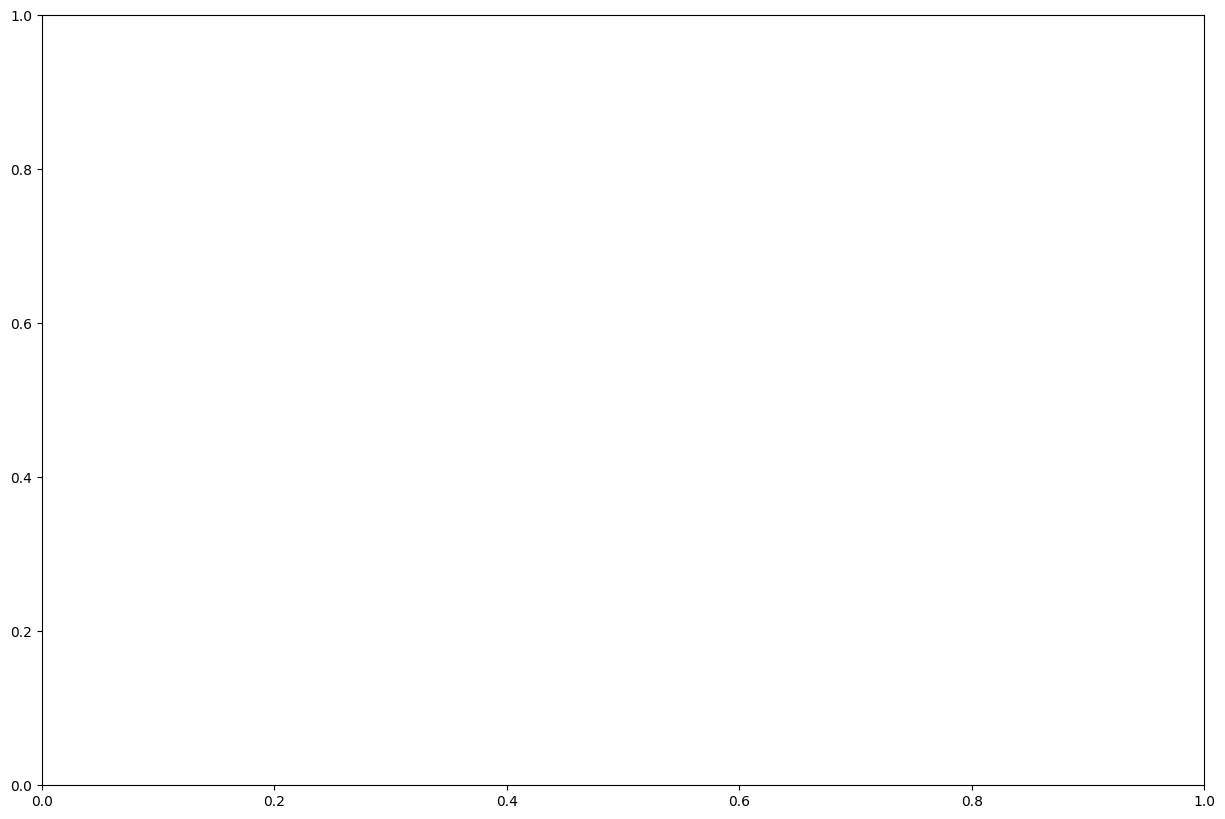

In [ ]:
# Plotting the training loss
plt.plot(range(1,num_epochs+1),train_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Training Loss")
plt.show()

ValueError: cannot reshape array of size 98304 into shape (64,64)

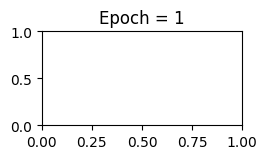

In [ ]:
# Plotting is done on a 7x5 subplot
# Plotting the reconstructed images

# Initializing subplot counter
counter = 1

# Plotting reconstructions
# for epochs = [1, 5, 10, 50, 100]
epochs_list = [1, 5, 10, 50]

# Iterating over specified epochs
for val in epochs_list:
	
	# Extracting recorded information
	temp = outputs[val]['out'].detach().cpu().numpy()
	title_text = f"Epoch = {val}"
	
	# Plotting first five images of the last batch
	for idx in range(4):
		plt.subplot(7, 5, counter)
		plt.title(title_text)
		plt.imshow(temp.reshape(resize_depth,resize_depth), cmap= 'gray')
		plt.axis('off')
		
		# Incrementing the subplot counter
		counter+=1

	# Plotting original images

	# Iterating over first five
	# images of the last batch
	for idx in range(4):
		
		# Obtaining image from the dictionary
		
		temp = outputs[val]['img'].detach().cpu().numpy()
		# Plotting image
		plt.subplot(7,5,counter)
		plt.imshow(temp.reshape(8, 8),
				cmap = 'gray')
		plt.title("Original Image")
		plt.axis('off')
		
		# Incrementing subplot counter
		counter+=1

plt.tight_layout()
plt.show()


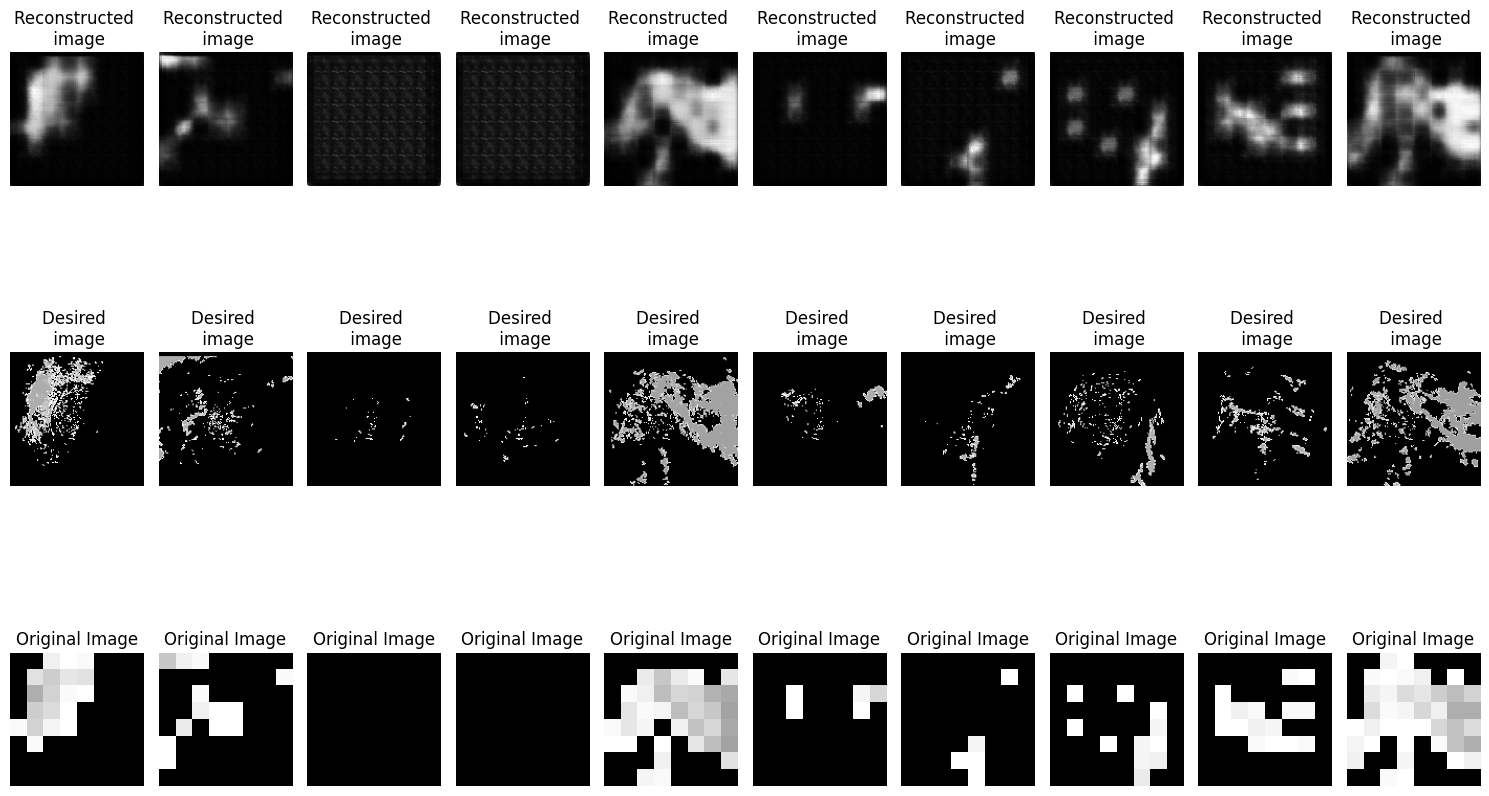

In [6]:
# Dictionary that will store the different
# images and outputs for various epochs
outputs = {}

# Extracting the last batch from the test
# dataset
validation_data = random.sample(train_data, 10)

scored_images = []


for val_item in validation_data:	
	
	# to_score = val_item[0].reshape(-1, 8*8)
	to_score = val_item[0].reshape(-1, 1, 8, 8)
	on_gpu = to_score.to('cuda')
	scored = model(on_gpu)
	
	scored_images.append((val_item[1], scored[0], val_item[0]))


# Generating output for the obtained
# batch


counter = 1


# Plotting first 10 images of the batch
for idx in range(len(scored_images)):
	plt.subplot(3, 10, counter)
	plt.title("Reconstructed \n image")
	plt.imshow(scored_images[idx][1].cpu().detach().reshape(resize_depth, resize_depth), cmap='gray')
	plt.axis('off')

	# Incrementing subplot counter
	counter += 1
 
for idx in range(len(scored_images)):
	plt.subplot(3, 10, counter)
	plt.title("Desired \n image")
	plt.imshow(scored_images[idx][0].cpu().detach().reshape(resize_depth, resize_depth), cmap='gray')
	plt.axis('off')

	# Incrementing subplot counter
	counter += 1

# Plotting original images

# Plotting first 10 images
for idx in range(len(scored_images)):
    
    plt.subplot(3, 10, counter)
    plt.imshow(scored_images[idx][2].reshape(8, 8), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

	# Incrementing subplot counter
    counter += 1

plt.tight_layout()
plt.show()


In [ ]:
torch.save(model.state_dict(), 'RADAR_UPSCALER.pth')

In [ ]:
model2 = DeepAutoencoder()
model2.load_state_dict(torch.load('RADAR_UPSCALER.pth'))
model2 = model.to('cuda')  # Don't forget to move the model to GPU if available